In [29]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Turn off annoying Pandas warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
#dqn = pickle.load(open("dqn_actions.pkl", "rb" ))
#krn = pickle.load(open("kernel_actions.pkl", "rb" ))
#moe = pickle.load(open("moe_actions.pkl", "rb" ))
#phy = pickle.load(open("phy_actions.pkl", "rb" ))
#rewards = pickle.load(open("rewards.pkl", "rb" ))
#test_moe_imp_weights = pickle.load(open("test_set_moe_importance_weights.pkl", "rb" ))
#train_scaled_with_ir = pd.read_csv("train_scaled_with_ir.csv")

In [3]:
#test_scaled_with_ir = pd.read_csv("test_scaled_with_ir.csv")
#test_scaled_with_ir.head()

In [4]:
test_set_with_actions = pickle.load(open("test_set_with_actions.pkl", "rb" ))


In [5]:
#test_set_with_actions.head()

In [6]:
#test_set_with_actions.columns.values

In [7]:
test_cleaned_obs = pd.read_csv("origin_test_clean.csv")
test_cleaned_obs.drop(test_cleaned_obs[test_cleaned_obs['icustayid'].
                       isin([37166.0,67895.0,68546.0,85154.0])].index,inplace=True)
test_cleaned_obs.drop(test_cleaned_obs[test_cleaned_obs['icustayid'].isnull()].index, inplace=True)


In [8]:
#test_cleaned_obs.columns.values

In [9]:
#test_cleaned_obs.head()

In [10]:
np.mean(test_set_with_actions.SOFA)

6.401640795608806

In [11]:
np.mean(test_cleaned_obs.SOFA)

6.401640795608806

In [12]:
test_set = pd.concat([test_cleaned_obs,test_set_with_actions[['traj_len','dist','reward','kernel','dqn','moe','phy']]],axis=1)

In [13]:
np.mean(test_set.SOFA)

6.401640795608806

In [14]:
test_set.columns.values

array(['bloc', 'icustayid', 'charttime', 'gender', 'age', 'elixhauser',
       're_admission', 'SOFA', 'SIRS', 'Weight_kg', 'GCS', 'HR', 'SysBP',
       'MeanBP', 'DiaBP', 'Shock_Index', 'RR', 'SpO2', 'Temp_C', 'FiO2_1',
       'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN', 'Creatinine',
       'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT', 'SGPT',
       'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'PaO2_FiO2', 'median_dose_vaso',
       'max_dose_vaso', 'input_total_tev', 'input_4hourly_tev',
       'output_total', 'output_4hourly', 'cumulated_balance_tev',
       'sedation', 'mechvent', 'rrt', 'died_in_hosp', 'mortality_90d',
       'traj_len', 'dist', 'reward', 'kernel', 'dqn', 'moe', 'phy'], dtype=object)

In [15]:
test_set.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,SOFA,SIRS,Weight_kg,...,rrt,died_in_hosp,mortality_90d,traj_len,dist,reward,kernel,dqn,moe,phy
0,1.0,61.0,5.177308e+09,0.0,16710.693588,3.0,0.0,12.0,3.0,250.0,...,0.0,0.0,0.0,1.0,0.982623,0.351480,0.0,0.0,0.0,20.0
1,2.0,61.0,5.177322e+09,0.0,16710.693588,3.0,0.0,8.0,3.0,250.0,...,0.0,0.0,0.0,2.0,1.737526,-0.472893,20.0,20.0,20.0,20.0
2,3.0,61.0,5.177336e+09,0.0,16710.693588,3.0,0.0,8.0,4.0,250.0,...,0.0,0.0,0.0,3.0,2.177648,0.148372,20.0,0.0,20.0,20.0
3,4.0,61.0,5.177351e+09,0.0,16710.693588,3.0,0.0,7.0,4.0,250.0,...,0.0,0.0,0.0,4.0,2.413630,-0.052440,20.0,0.0,20.0,20.0
4,5.0,61.0,5.177365e+09,0.0,16710.693588,3.0,0.0,7.0,4.0,250.0,...,0.0,0.0,0.0,5.0,2.553184,-0.031333,20.0,0.0,20.0,20.0


## Single Patient Trajectory

In [16]:
def plot_patient_traj(icuid, attrs, df):
    
    plt.figure(figsize=(10, int(2 * len(attrs))), dpi=150)
    patient_obsers = df[df['icustayid'] == icuid]
    
    actions = patient_obsers['moe'].values
    phy = patient_obsers['phy'].values
    
    vaso = actions % 5
    iv = actions // 5
    
    patient_obsers['step'] = np.arange(patient_obsers.shape[0]) + 1
    annotation = []
    for i, (i_dose, v_dose) in enumerate(zip(iv, vaso)):
        annotation += ["i:{}/{}\nv:{}/{}".format(i_dose, phy[i]//5, v_dose, phy[i]%5)]
        
    if patient_obsers['died_in_hosp'].iloc[0] == 1:
        c = 'red'
    else:
        c = 'green'

    for i, attr in enumerate(attrs):
        plt.subplot(len(attrs), 1, i+1)
        ax = sns.regplot(x='step', y=attr, data=patient_obsers, fit_reg=False, marker="+", color=c)
        ax.set_xlabel('')
        for s, ann in enumerate(annotation):
            if vaso[s] != 0 or iv[s] != 0:
                ax.text(patient_obsers['step'].iloc[s]+0.1, patient_obsers[attr].iloc[s], ann, \
                        horizontalalignment='left', size='small', color='black', weight='light')
    
    plt.show()


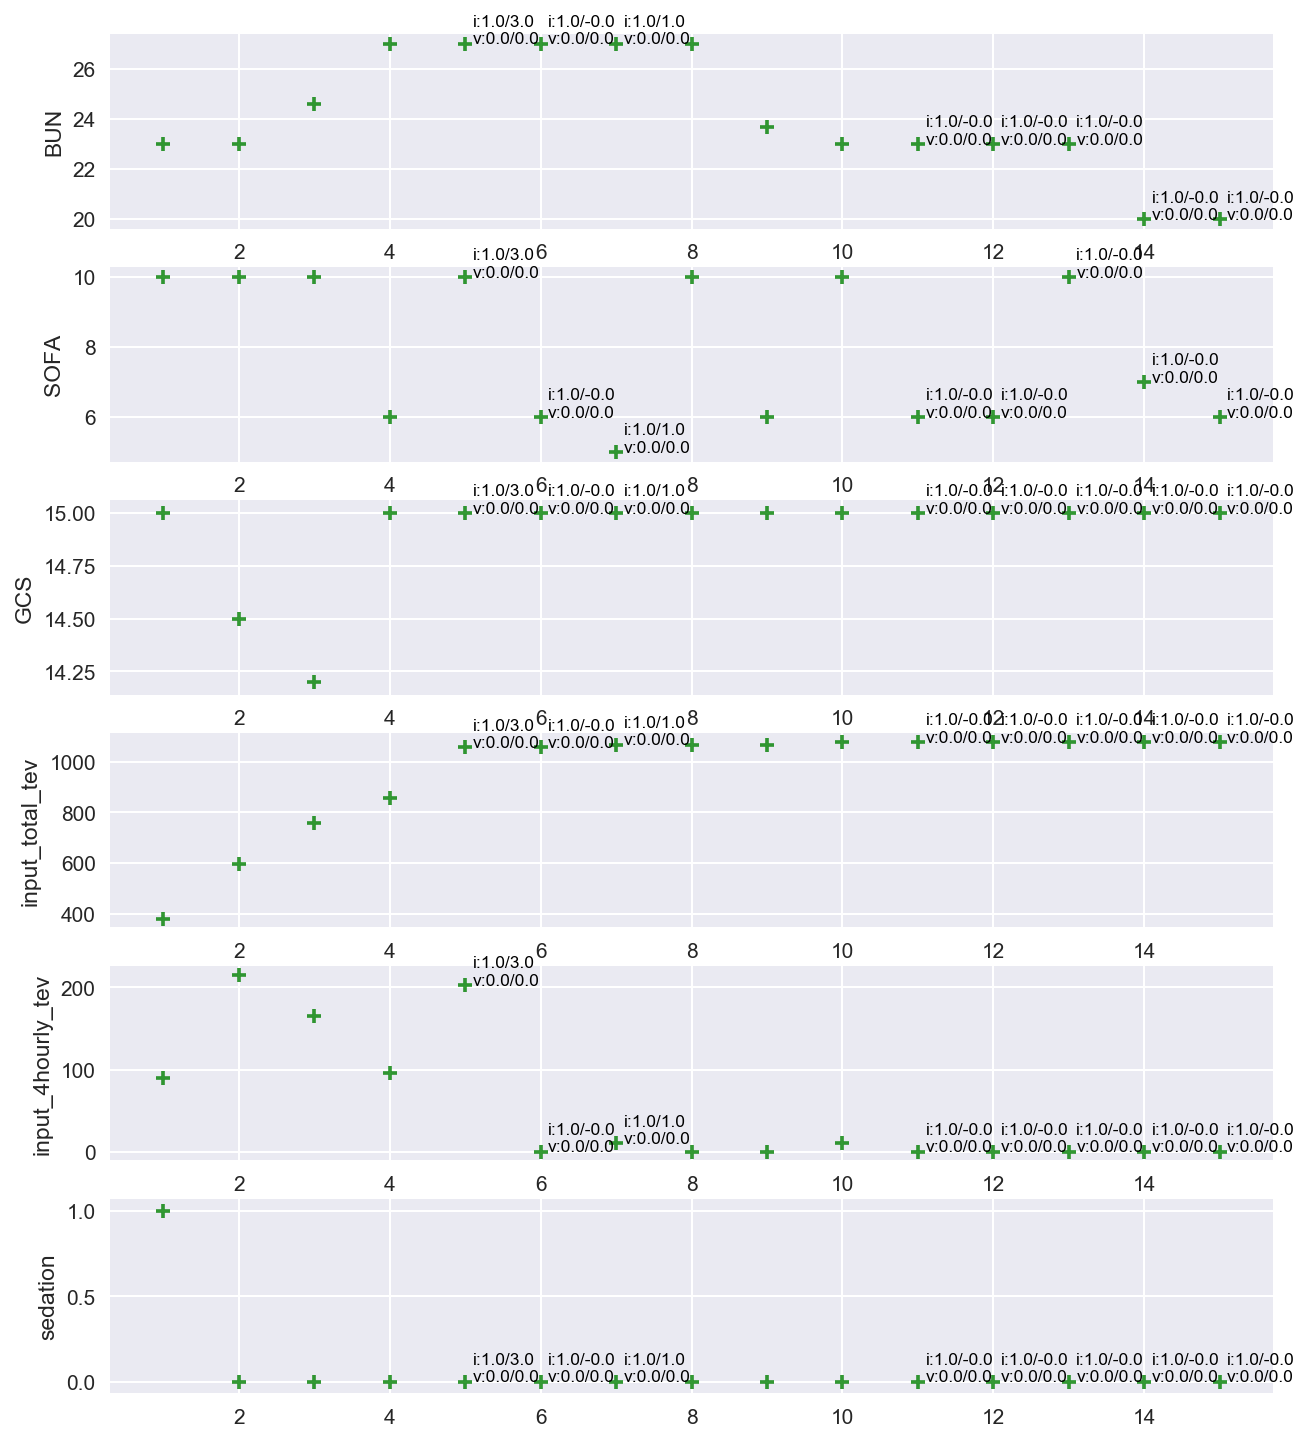

In [79]:
plot_patient_traj(1774, ['BUN','SOFA','GCS',
        'input_total_tev', 'input_4hourly_tev','sedation'], test_set)

## Distribution of Actions, Actions based on SOFA, Distance

In [50]:
def show_hist(df,col):
    plt.hist(df[~np.isnan(df[col])][col])

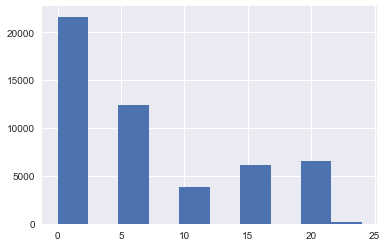

In [51]:
show_hist(test_set,'moe')

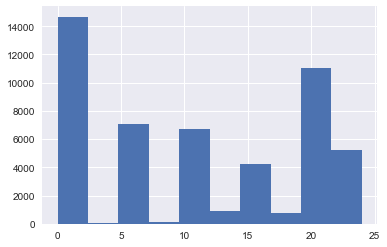

In [52]:
show_hist(test_set,'dqn')

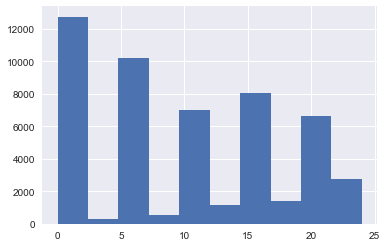

In [54]:
show_hist(test_set,'phy')

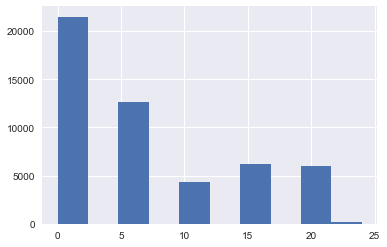

In [55]:
show_hist(test_set,'kernel')

## Action Agreement

In [86]:
print("MOE and DQN agree:",len(test_set[test_set.moe == test_set.dqn]))
print("Mean SOFA when MOE and DQN agree:",np.mean(test_set[test_set.moe == test_set.dqn].SOFA))
print("Mean Dist when MOE and DQN agree:",np.mean(test_set[test_set.moe == test_set.dqn].dist))
print("Mean Reward when MOE and DQN agree:",np.mean(test_set[test_set.moe == test_set.dqn].reward))
print("Mean Reward when MOE and DQN disagree:",np.mean(test_set[test_set.moe != test_set.dqn].reward))

MOE and DQN agree: 13100
Mean SOFA when MOE and DQN agree: 6.1414280259641085
Mean Dist when MOE and DQN agree: 1.833491345454634
Mean Reward when MOE and DQN agree: 0.02784238027707311
Mean Reward when MOE and DQN disagree: 0.014193955785871964


In [85]:
print("MOE and PHY agree:",len(test_set[test_set.moe == test_set.phy]))
print("Mean SOFA when MOE and PHY agree:",np.mean(test_set[test_set.moe == test_set.phy].SOFA))
print("Mean dist when MOE and PHY agree:",np.mean(test_set[test_set.moe == test_set.phy].dist))
print("Mean Reward when MOE and PHY agree:",np.mean(test_set[test_set.moe == test_set.phy].reward))
print("Mean Reward when MOE and PHY disagree:",np.mean(test_set[test_set.moe != test_set.phy].reward))

MOE and PHY agree: 15070
Mean SOFA when MOE and PHY agree: 6.103445986322289
Mean dist when MOE and PHY agree: 1.7653117238164877
Mean Reward when MOE and PHY agree: -0.0016563170978227196
Mean Reward when MOE and PHY disagree: 0.02587375592547357


In [89]:
print("MOE and Kernel agree:",len(test_set[test_set.moe == test_set.kernel]))
print("Mean SOFA when MOE and kernel agree:",np.mean(test_set[test_set.moe == test_set.kernel].SOFA))
print("Mean dist when MOE and kernel agree:",np.mean(test_set[test_set.moe == test_set.kernel].dist))
print("Mean Reward when MOE and kernel agree:",np.mean(test_set[test_set.moe == test_set.kernel].reward))
print("Mean Reward when MOE and kernel disagree:",np.mean(test_set[test_set.moe != test_set.kernel].reward))

MOE and Kernel agree: 44255
Mean SOFA when MOE and kernel agree: 6.428836283886138
Mean dist when MOE and kernel agree: 1.851033870504251
Mean Reward when MOE and kernel agree: 0.019380785890682015
Mean Reward when MOE and kernel disagree: 0.0064743321999830425


In [102]:
tot = len(test_set)
moe_krn = len(test_set[test_set.moe == test_set.kernel]) / tot
print("moe kernel",moe_krn)
moe_dqn= len(test_set[test_set.moe == test_set.dqn]) / tot
print("moe dqn",moe_dqn)
moe_phy= len(test_set[test_set.moe == test_set.phy]) / tot
print ("moe phy",moe_phy)
phy_krn = len(test_set[test_set.phy == test_set.kernel]) / tot
print("phy kernel", phy_krn)
dqn_krn =len(test_set[test_set.dqn == test_set.kernel]) / tot
print ("dqn kernel",dqn_krn)
phy_dqn = len(test_set[test_set.phy == test_set.dqn]) / tot
print ("phy dqn", phy_dqn)
#phy_phy =len(test_set[test_set.phy == test_set.phy]) / tot


moe kernel 0.8701508090996677
moe dqn 0.25757486383924183
moe phy 0.29630940443186066
phy kernel 0.3048428006842447
dqn kernel 0.18144281248156668
phy dqn 0.15045518000747163


 ### Frequency of agreement between experts 
 | | Phy | Kernel | DQN
|:---|---|---|---|---|
| MoE | 29.6% | 87.0% | 25.6% | 
|Phy |   | 30.5%  | 15.0%  |
|Kernel |  |  | 18.1% |


### Patient demographic by expert

Age, mean, quartile
SOFA


XXX

DQN dominant
Kernel dominant

how does trajectory length affect expert selection

XXX:
Filtering only patient who live in kernel is tainting the treatment

makes kernel too conservative

Will DQN kick for more sick patients?

Don't make too many claims for the kernel expert when it is based only on survivors.

Adjust only very sick patients?

Upon what basis is a particular action better?

In what circumstances was the DQN picked? small trajectory? demographic? variance of SOFA? trend of SOFA? show evidence

discounted expected return for a subgroup?


In [124]:
# https://stackoverflow.com/a/4777781
from collections import Counter

def numDups(a, b):
    if len(a)>len(b):
        a,b = b,a

    a_count = Counter(a)
    b_count = Counter(b)

    return sum(min(b_count[ak], av) for ak,av in a_count.items())

In [246]:
df = test_set.sort_values(['icustayid','bloc'])
test_episodes = df.groupby('icustayid')
#test_episodes = test_set.groupby('icustayid')
max_episodes = len(test_episodes)
n_episodes = max_episodes
sum_kernel = 0.
sum_dqn = 0.
num_dqn_chosen = 0
dqn_chosen_custids = []
traj_len_kernel = []
traj_len_dqn = []
max_dist_dqn = []
max_dist_kernel = []
mean_sofa_init_dqn = []
mean_sofa_final_dqn = []
mean_sofa_init_kernel = []
mean_sofa_final_kernel = []
num_init_dqn = 0
num_init_kernel = 0
num_final_dqn = 0
num_final_kernel = 0
num_sofa_improved = 0
num_sofa_worsened = 0
num_sofa_constant = 0
for name, transitions in test_episodes:

    phy = transitions['phy'].tolist()
    kernel = transitions['kernel'].tolist()
    dqn = transitions['dqn'].tolist()
    moe = transitions['moe'].tolist()
    pct_kernel = numDups(kernel,moe) / len(phy)*100
    sum_kernel += pct_kernel
    pct_dqn = numDups(dqn,moe) / len(phy)*100
    sum_dqn += pct_dqn
    #print ("Kernel: {0:0.2f} \t\tDQN: {1:0.2f}%".format(pct_kernel,pct_dqn))
    if pct_dqn > pct_kernel:
        num_dqn_chosen += 1
        #print (transitions['icustayid'].tolist()[0])
        dqn_chosen_custids.append(transitions['icustayid'].tolist()[0])
        traj_len_dqn.append(len(phy))
        max_dist_dqn.append(max(transitions['dist']))
        mean_sofa_init_dqn.append(np.mean(transitions.SOFA[0:2]))
        mean_sofa_final_dqn.append(np.mean(transitions.SOFA[-3:]))
    else:
        traj_len_kernel.append(len(phy))
        max_dist_kernel.append(max(transitions['dist']))
        mean_sofa_init_kernel.append(np.mean(transitions.SOFA[0:2]))
        mean_sofa_final_kernel.append(np.mean(transitions.SOFA[-3:]))
    # find which expert was favored for first three transitions and for last three transitions
    pct_init_dqn = numDups(dqn[0:2],moe[0:2]) 
    pct_init_kernel = numDups(kernel[0:2],moe[0:2])
    if pct_init_dqn > pct_init_kernel:
        num_init_dqn += 1
    else:
        num_init_kernel += 1
    pct_final_dqn = numDups(dqn[-3:],moe[-3:])
    pct_final_kernel = numDups(kernel[-3:],moe[-3:])
    if pct_final_dqn > pct_final_kernel:
        num_final_dqn += 1
    else:
        num_final_kernel += 1
    if np.mean(transitions.SOFA[0:2] < np.mean(transitions.SOFA[-3:])):
        num_sofa_worsened += 1
    elif np.mean(transitions.SOFA[0:2] > np.mean(transitions.SOFA[-3:])):
        num_sofa_improved += 1
    else:
        num_sofa_constant += 1
    n_episodes -= 1
    if n_episodes == 0:
        break
        
max_dist_kernel = [x for x in max_dist_kernel if not np.isnan(x)]
print ("avg Kernel:",sum_kernel/max_episodes)
print ("avg DQN:",sum_dqn/max_episodes)
print ("DQN chosen:",num_dqn_chosen)

avg Kernel: 88.56844648679856
avg DQN: 40.93770342069102
DQN chosen: 217


In [249]:

print ("DQN SOFA start/end:",np.mean(mean_sofa_init_dqn),np.mean(mean_sofa_final_dqn),
       "Kernel SOFA start / end:",np.mean(mean_sofa_init_kernel),np.mean(mean_sofa_final_kernel))
print ("SOFA percentage worsened:",num_sofa_worsened/max_episodes,
       "improved:",num_sofa_improved/max_episodes,
       "constant:",num_sofa_constant/max_episodes)
print ("DQN initial:",num_init_dqn,"final:",num_final_dqn)
print ("Kernel initial:",num_init_kernel,"final:",num_final_kernel)

DQN SOFA start/end: 6.93778801843 6.10752688172 Kernel SOFA start / end: 7.12727022565 6.26926252064
SOFA percentage worsened: 0.4435211633341989 improved: 0.5063619839002856 constant: 0.05011685276551545
DQN initial: 155 final: 373
Kernel initial: 3696 final: 3478


2.15529968606
0.0514018774247


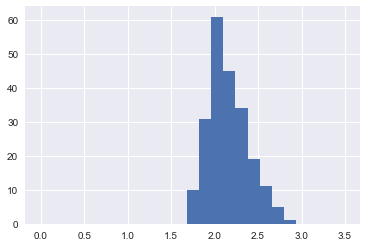

In [218]:
plt.hist(max_dist_dqn,range=[0.0,3.5],bins=25)
print(np.mean(max_dist_dqn))
print(np.var(max_dist_dqn))

2.12804004731
0.068625631474


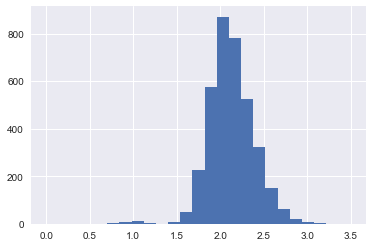

In [219]:
plt.hist(max_dist_kernel,range=[0.0,3.5],bins=25)
print(np.mean(max_dist_kernel))
print(np.var(max_dist_kernel))

(array([ 218.,  461.,  727.,  725.,  491.,  256.,  109.,   44.,   37.,    5.]),
 array([  0. ,   1.9,   3.8,   5.7,   7.6,   9.5,  11.4,  13.3,  15.2,
         17.1,  19. ]),
 <a list of 10 Patch objects>)

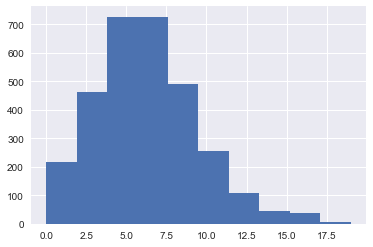

In [174]:
plt.hist(test_set[test_set.icustayid.isin(dqn_chosen_custids)].SOFA)


(array([  5704.,   9886.,  10788.,   9177.,   6169.,   4195.,   1077.,
           501.,    177.,     82.]),
 array([  0. ,   2.2,   4.4,   6.6,   8.8,  11. ,  13.2,  15.4,  17.6,
         19.8,  22. ]),
 <a list of 10 Patch objects>)

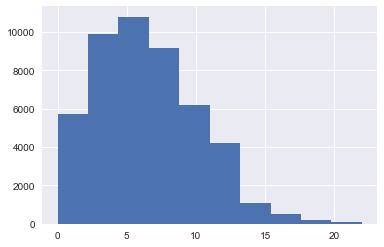

In [155]:
plt.hist(test_set[~test_set.icustayid.isin(dqn_chosen_custids)].SOFA.dropna())

14.1612903226
21.4716812844


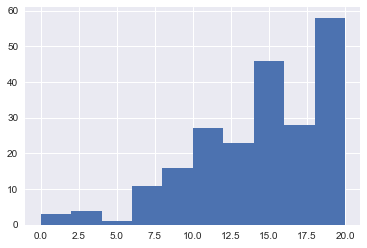

In [222]:
plt.hist(traj_len_dqn,range=[0,20])
print(np.mean(traj_len_dqn))
print(np.var(traj_len_dqn))

13.1414419373
21.2975505901


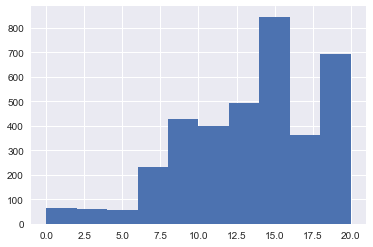

In [223]:
plt.hist(traj_len_kernel,range=[0,20])
print(np.mean(traj_len_kernel))
print(np.var(traj_len_kernel))

In [175]:
# percent time DQN is chosen more frequently than Kernel for a given patient trajectory
len(dqn_chosen_custids) / max_episodes

0.056349000259672814

In [189]:
def in_out_mean_var(df,select_col,selection,columns):
    var_ins = []
    var_outs = []
    for col in columns:
        print("Column:",col)
        print("\tMean in:",np.mean(df[df[select_col].isin(selection)][col].dropna()))
        var_in = np.var(df[df[select_col].isin(selection)][col].dropna())
        var_ins.append(var_in)
        print("\tVar in:",var_in)
        print("\tMean out:",np.mean(df[~df[select_col].isin(selection)][col].dropna()))
        var_out = np.var(df[~df[select_col].isin(selection)][col].dropna())
        var_outs.append(var_out)
        print("\tVar out:",var_out)
        print()
    print ("mean var in:",np.mean(var_ins))
    print ("median var in:",np.median(var_ins))
    print ("mean var out:",np.mean(var_outs))
    print ("median var out:",np.median(var_outs))


In [190]:
in_out_mean_var(test_set,'icustayid',dqn_chosen_custids,
                ['SOFA','age','FiO2_1','elixhauser','GCS','BUN','Albumin','dist']) # XXX

Column: SOFA
	Mean in: 6.109013992840872
	Var in: 11.307022555287489
	Mean out: 6.420470726191473
	Var out: 12.531513272009668

Column: age
	Mean in: 23026.929847601117
	Var in: 44022179.977813594
	Mean out: 23868.345810620347
	Var out: 36727059.662330195

Column: FiO2_1
	Mean in: 0.5078126298011132
	Var in: 0.0458618568345297
	Mean out: 0.5034958163984369
	Var out: 0.04226861847384634

Column: elixhauser
	Mean in: 3.957370647575659
	Var in: 3.8728980002709017
	Mean out: 3.9245225730798223
	Var out: 4.7079774510862595

Column: GCS
	Mean in: 12.478913535902556
	Var in: 12.342638898686632
	Mean out: 12.168852528250653
	Var out: 13.31791091039115

Column: BUN
	Mean in: 32.22088401497279
	Var in: 696.1403764777067
	Mean out: 29.07869749790604
	Var out: 540.659069318974

Column: Albumin
	Mean in: 3.067047012170035
	Var in: 0.4336813156668
	Mean out: 3.0160007100641306
	Var out: 0.3668319785819674

Column: dist
	Mean in: 1.907071825658926
	Var in: 0.15213785754824416
	Mean out: 1.86650418208

### Summary of Results

| | DQN Favored | Kernel Favored |
|:--|-------:|----:|
| Percent of Patients | 5.6% | 94.4% |
|Mean SOFA | 6.11 | 6.42 |
| Var(SOFA) |11.31 | 12.53|
| Mean Age (days) | 23026 | 23868 | 
| Var Age | 44022179 | 36727059 |
| FiO2 | 0.51 | 0.50 | 
| Var FiO2 | 0.05 | 0.04 |
| Elixhauser | 3.96 | 3.92 |
| Var Exlihauser | 3.87 | 4.71 |
| GCS | 12.48 | 12.17 |
| Var GCS | 12.34 | 13.32 |
| BUN | 32.22 | 29.08 | 
| Var BUN | 696.14 | 540.66 |
| Albumin | 3.07 | 3.02 |
| Var Albumin | 0.43 | 0.37 |
| Distance | 1.91 | 1.87 |
| Var Distance | 0.15 | 0.18 |
| Trajectory length |14.16 |13.14 |

Summary:
* The DQN is favored for patients that are further from center as well as having higher variance, especially w.r.t. age and BUN

I think this is a reasonable and defensible conclusion.

### Switching between experts during episode

In [303]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap(['r', 'g'])
norm = BoundaryNorm([-1, 0,1], cmap.N)


In [293]:
y = [4.666666666666667, 8.6666666666666661, 
                     4.333333333333333, 5.0, 3.3333333333333335, 
                     3.6666666666666665, 5.0]
x = list(range(0,len(y)))
z = [1, 1, 1, 1, 1, 1, -1]
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)


lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(z)
lc.set_linewidth(3)

fig1 = plt.figure()
plt.gca().add_collection(lc)


AttributeError: 'list' object has no attribute 'ndim'

(-1.1, 1.1)

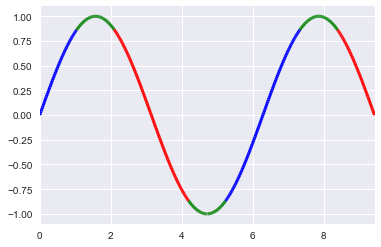

In [306]:
x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
z = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a colormap for red, green and blue and a norm to color
# f' < -0.5 red, f' > 0.5 blue, and the rest green
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be numlines x points per line x 2 (x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object, setting the colormapping parameters.
# Have to set the actual values used for colormapping separately.
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(z)
lc.set_linewidth(3)

fig1 = plt.figure()
plt.gca().add_collection(lc)
plt.xlim(x.min(), x.max())
plt.ylim(-1.1, 1.1)


In [313]:
lc.get_segments()


[array([[ 0.        ,  0.        ],
        [ 0.01888733,  0.01888621]]), array([[ 0.01888733,  0.01888621],
        [ 0.03777466,  0.03776568]]), array([[ 0.03777466,  0.03776568],
        [ 0.05666199,  0.05663168]]), array([[ 0.05666199,  0.05663168],
        [ 0.07554932,  0.07547747]]), array([[ 0.07554932,  0.07547747],
        [ 0.09443665,  0.09429635]]), array([[ 0.09443665,  0.09429635],
        [ 0.11332398,  0.11308158]]), array([[ 0.11332398,  0.11308158],
        [ 0.13221131,  0.13182648]]), array([[ 0.13221131,  0.13182648],
        [ 0.15109864,  0.15052435]]), array([[ 0.15109864,  0.15052435],
        [ 0.16998598,  0.16916853]]), array([[ 0.16998598,  0.16916853],
        [ 0.18887331,  0.18775236]]), array([[ 0.18887331,  0.18775236],
        [ 0.20776064,  0.20626921]]), array([[ 0.20776064,  0.20626921],
        [ 0.22664797,  0.22471249]]), array([[ 0.22664797,  0.22471249],
        [ 0.2455353 ,  0.2430756 ]]), array([[ 0.2455353 ,  0.2430756 ],
        [ 0.264

In [264]:
max_episodes = len(test_episodes)
n_episodes = 10
time_window = 3

for name, transitions in test_episodes:
    episode_len = len(transitions['phy'].tolist())
    SOFA = transitions.SOFA.tolist()
    kernel = transitions['kernel'].tolist()
    dqn = transitions['dqn'].tolist()
    moe = transitions['moe'].tolist()

    SOFA_by_12hr = []
    expert_by_12hr = []
    trend = []
    
    for start in range(0,episode_len,time_window):
        SOFA_by_12hr.append(np.mean(SOFA[start:start+3]) )
        pct_kernel = numDups(kernel[start:start+3],moe[start:start+time_window]) / time_window
        pct_dqn = numDups(dqn[start:start+time_window],moe[start:start+time_window]) / time_window
        if pct_kernel > pct_dqn:
            expert_by_12hr.append(1)
        else:
            expert_by_12hr.append(-1)
    if SOFA_by_12hr[0] > SOFA_by_12hr[-1]:
        print("better: ",end="")
    else:
        print("worse: ",end="")
        
    print(SOFA_by_12hr)
    print(expert_by_12hr,'\n')
    n_episodes -= 1
    if n_episodes == 0:
        break



better: [9.3333333333333339, 7.0, 7.333333333333333, 8.0, 8.0]
[1, 1, 1, 1, 1] 

better: [8.0, 5.0]
[1, 1] 

worse: [4.666666666666667, 8.6666666666666661, 4.333333333333333, 5.0, 3.3333333333333335, 3.6666666666666665, 5.0]
[1, 1, 1, 1, 1, 1, -1] 

worse: [1.0, 2.0, 4.0]
[1, 1, 1] 

worse: [5.0, 7.333333333333333, 8.5]
[1, 1, 1] 

worse: [5.333333333333333, 7.333333333333333, 8.0, 12.0]
[1, 1, -1, 1] 

worse: [5.0, 5.0, 6.333333333333333, 9.0]
[1, 1, -1, 1] 

better: [4.333333333333333, 3.6666666666666665, 2.6666666666666665, 2.0, 4.0]
[1, -1, 1, 1, 1] 

worse: [3.3333333333333335, 2.0, 2.0, 4.0]
[1, 1, -1, 1] 

better: [14.0, 14.333333333333334, 12.0, 11.333333333333334, 11.0]
[-1, 1, 1, 1, 1] 



### Exploration of MoE action that does not correspond to either expert

In [83]:
np.mean(test_set.reward)

0.01771152175873657

In [45]:
diff_moe = test_set[(test_set.moe != test_set.phy) & 
                    (test_set.moe != test_set.kernel) & 
                    (test_set.moe != test_set.dqn)]

In [74]:
print("{0:.2f}% when MOE is new".format(len(diff_moe)/len(test_set)*100.))

4.37% when MOE is new


In [70]:
print("Mean SOFA when MOE is new:",np.mean(diff_moe.SOFA))
print("Mean dist when MOE is new:",np.mean(diff_moe.dist))

Mean SOFA when MOE is new: 6.644594594594595
Mean dist when MOE is new: 2.0130234650075804


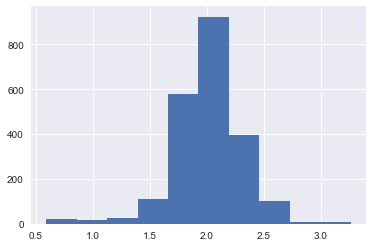

In [56]:
show_hist(diff_moe,'dist')

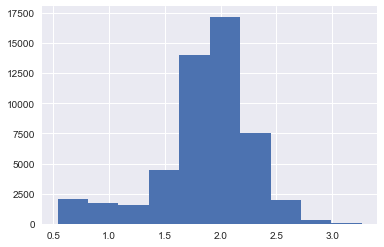

In [57]:
show_hist(test_set,'dist')

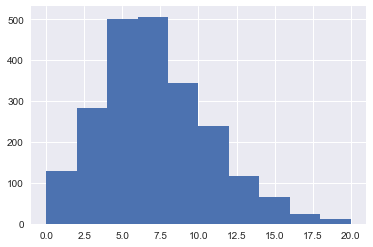

In [58]:
show_hist(diff_moe,'SOFA')

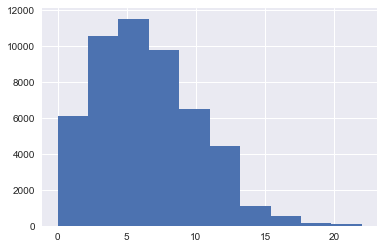

In [59]:
show_hist(test_set,'SOFA')

In [251]:
diff_moe.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,SOFA,SIRS,Weight_kg,...,rrt,died_in_hosp,mortality_90d,traj_len,dist,reward,kernel,dqn,moe,phy
143,9.0,322.0,6.257963e+09,1.0,20129.622975,3.0,0.0,5.0,1.0,62.293749,...,0.0,0.0,0.0,9.0,1.716186,-0.834654,5.0,0.0,15.0,0.0
204,11.0,569.0,4.773726e+09,0.0,19546.066331,2.0,0.0,7.0,2.0,67.000000,...,0.0,1.0,1.0,11.0,1.738490,0.060549,10.0,0.0,5.0,15.0
265,6.0,664.0,5.162264e+09,0.0,26329.806088,4.0,1.0,5.0,1.0,62.900000,...,0.0,0.0,0.0,6.0,1.578996,0.601172,5.0,0.0,15.0,20.0
266,7.0,664.0,5.162278e+09,0.0,26329.806088,4.0,1.0,3.0,0.0,62.900000,...,0.0,0.0,0.0,7.0,1.595791,-0.436361,5.0,15.0,0.0,15.0
319,12.0,708.0,5.789963e+09,1.0,16351.442350,2.0,0.0,4.0,3.0,73.200000,...,0.0,0.0,0.0,11.0,2.116907,0.050896,20.0,24.0,15.0,20.0


### Cohort Data

In [327]:
train_set = pd.read_csv("origin_train_clean.csv")

In [328]:
len(train_set)

150741

In [358]:
train_set_grp = train_set.groupby('icustayid')

In [317]:
len(train_set_grp)

11560

In [318]:
len(test_episodes)

3851

In [319]:
3851 / (11560+3851)

0.24988644474725846

In [320]:
11560+3851

15411

In [324]:
train_set.columns.values

array(['Unnamed: 0', 'bloc', 'icustayid', 'gender', 'age', 'elixhauser',
       're_admission', 'SOFA', 'SIRS', 'Weight_kg', 'GCS', 'HR', 'SysBP',
       'MeanBP', 'DiaBP', 'Shock_Index', 'RR', 'SpO2', 'Temp_C', 'FiO2_1',
       'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN', 'Creatinine',
       'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT', 'SGPT',
       'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count',
       'PTT', 'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'PaO2_FiO2', 'median_dose_vaso',
       'max_dose_vaso', 'input_total_tev', 'input_4hourly_tev',
       'output_total', 'output_4hourly', 'cumulated_balance_tev',
       'sedation', 'mechvent', 'rrt', 'died_in_hosp', 'mortality_90d',
       'reward', 'vaso_input', 'iv_input', 'neg_mortality_logodds'], dtype=object)

In [330]:
min(train_set.age) / 365.25

18.075649162166954

In [332]:
max(train_set.age) / 365.25

91.399999999999991

In [333]:
train_set.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,SOFA,SIRS,Weight_kg,...,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,sedation,mechvent,rrt,died_in_hosp,mortality_90d
0,1.0,12.0,5.805744e+09,1.0,12049.217303,0.0,0.0,7.0,1.0,51.200001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,12.0,5.805758e+09,1.0,12049.217303,0.0,0.0,3.0,2.0,51.200001,...,0.0,0.0,650.0,650.0,-650.0,0.0,0.0,0.0,0.0,0.0
2,3.0,12.0,5.805773e+09,1.0,12049.217303,0.0,0.0,2.0,2.0,51.200001,...,0.0,0.0,1200.0,550.0,-1200.0,0.0,0.0,0.0,0.0,0.0
3,4.0,12.0,5.805787e+09,1.0,12049.217303,0.0,0.0,5.0,2.0,51.200001,...,0.0,0.0,1200.0,0.0,-1200.0,0.0,0.0,0.0,0.0,0.0
4,1.0,14.0,4.264269e+09,0.0,30946.970000,2.0,0.0,5.0,2.0,56.872728,...,1300.0,1300.0,340.0,160.0,960.0,1.0,1.0,0.0,0.0,1.0


In [375]:
def group_totals(df, field):
    nonzero = 0
    zero = 0
    for name, group in df:
        if group[field].tolist()[0] != 0.0:
            nonzero += 1
        else:
            zero += 1
    return (zero, nonzero)

In [376]:
# train set males vs female 
group_totals(train_set_grp,'gender')

(6441, 5123)

In [377]:
# test set males vs female 
group_totals(test_episodes,'gender')

(2177, 1674)

In [378]:
# train_set died in hospital, lived vs died
group_totals(train_set_grp,'died_in_hosp')


(10157, 1407)

In [379]:
# train_set died in hospital, lived vs died
group_totals(test_episodes,'died_in_hosp')


(3378, 473)

#### subset survivors vs. non-survivors

In [383]:
# did not survive, train set: gender m vs f
df = train_set[train_set.died_in_hosp != 0.0]
df_grp = df.groupby('icustayid')
group_totals(df_grp,'gender')

(781, 626)

In [384]:
# survived, test set: gender m vs f
df = train_set[train_set.died_in_hosp == 0.0]
df_grp = df.groupby('icustayid')
group_totals(df_grp,'gender')

(5660, 4497)

In [385]:
# did not survive, test set: gender m vs f
df = test_set[test_set.died_in_hosp != 0.0]
df_grp = df.groupby('icustayid')
group_totals(df_grp,'gender')

(266, 207)

In [386]:
#  survived, test set: gender m vs f
df = test_set[test_set.died_in_hosp == 0.0]
df_grp = df.groupby('icustayid')
group_totals(df_grp,'gender')

(1911, 1467)

In [391]:
# survived females percentage:
survived_total = 5660 + 4497 + 1911 + 1467
survived_females = 4497 + 1467
print ("percent survived females:", survived_females / survived_total)
print ("total survived", survived_total)
nonsurvive_total = 781 + 626 + 266 + 207
nonsurvived_females = 626+207
print ("percent nonsurviving females:",nonsurvived_females / nonsurvive_total)
print ("total nonsurvived:", nonsurvive_total)
print ("grand total:",survived_total + nonsurvive_total)

percent survived females: 0.4406353897303288
total survived 13535
percent nonsurviving females: 0.4430851063829787
total nonsurvived: 1880
grand total: 15415


In [394]:
# mean age
survivor_ages = []
nonsurvivor_ages = []

df = train_set[train_set.died_in_hosp != 0.0]
df_grp = df.groupby('icustayid')
for name, group in df_grp:
    nonsurvivor_ages.append(group.age.tolist()[0] // 365.25)

df = test_set[train_set.died_in_hosp != 0.0]
df_grp = df.groupby('icustayid')
for name, group in df_grp:
    nonsurvivor_ages.append(group.age.tolist()[0] // 365.25)

df = train_set[train_set.died_in_hosp == 0.0]
df_grp = df.groupby('icustayid')
for name, group in df_grp:
    survivor_ages.append(group.age.tolist()[0] // 365.25)

df = test_set[train_set.died_in_hosp == 0.0]
df_grp = df.groupby('icustayid')
for name, group in df_grp:
    survivor_ages.append(group.age.tolist()[0] // 365.25)



63.871685571851742

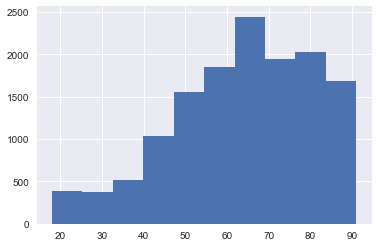

In [398]:
plt.hist(survivor_ages)
np.mean(survivor_ages)

67.395013123359576

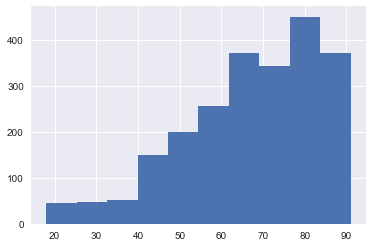

In [399]:
plt.hist(nonsurvivor_ages)
np.mean(nonsurvivor_ages)

#### Summary 

|  | % Female | Mean Age | Total Population | 
|---|----|----|---|
| Survivors | 44.1% |  | 13535 |
| Non-survivors | 44.3% | | 1880 |


In [400]:
len(train_set)

150741

In [401]:
13535 + 1880

15415

In [403]:
len(train_set.columns.values) - 9

50